In [1]:
import numpy as np
import pCN_sampler as pcn
import darcySolver as ds
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from tqdm.auto import tqdm

from scipy.spatial import distance_matrix
import os

os.nice(10)
plt.style.use('ggplot')


In [2]:
class PCA_transformer():
    def __init__(self,cov_mat,rank):
        self.cov_mat=cov_mat
        self.rank=rank
        eigenvalues,eigenvectors=np.linalg.eigh(cov_mat)
        eigenvectors=eigenvectors[:,::-1]
        eigenvalues=eigenvalues[::-1]
        self.sigma=eigenvalues
        self.P_full=eigenvectors
        self.P=eigenvectors[:,:rank]
        self.uncertainty_mat=self.P_full[:,rank:]@np.diag(self.sigma[rank:])@self.P_full[:,rank:].T
    
    def transform(self,x):
        variance_scaling=np.diag(1/np.sqrt(self.sigma[:self.rank]))
        if len(x.shape)==2:
            return x@self.P@variance_scaling
        else:
            return variance_scaling@self.P.T@x
    
    def inverse_transform(self,v):
        inv_variance_scaling = np.diag(np.sqrt(self.sigma[:self.rank]))
        if len(v.shape)==2:
            return v@inv_variance_scaling@self.P.T
        else:
            return self.P@inv_variance_scaling@v

In [3]:
prior_cov = np.load("data_old_wider_bandwidth/kernel_matrix_prior.npy")
pca = PCA_transformer(prior_cov, 40)
#mgan_samples = np.load('MCMC_results_old/MGAN_samples.npy')
extra_pca_variance = np.diag(pca.uncertainty_mat).reshape(40,40)

In [6]:
mcmc_samples=[]
acceptance = []
phi_vals = []
for i in tqdm(range(50)):
    path_prefix = f"MCMC_results/batch_{f'{000+i}'.zfill(3)}"
    mcmc_samples += [np.load(path_prefix + "u_samples.npy")]
    acceptance += [np.load(path_prefix + "acceptance.npy")]
    phi_vals += [np.load(path_prefix + "phi_vals.npy")]

mcmc_samples = np.vstack(mcmc_samples)
acceptance = np.vstack(acceptance)
phi_vals = np.vstack(phi_vals)

true_permeability = np.load("MCMC_results/true_permeability.npy")

  0%|          | 0/50 [00:00<?, ?it/s]

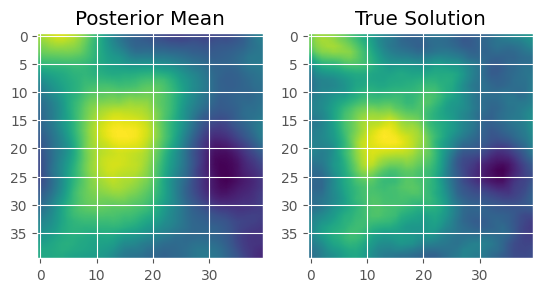

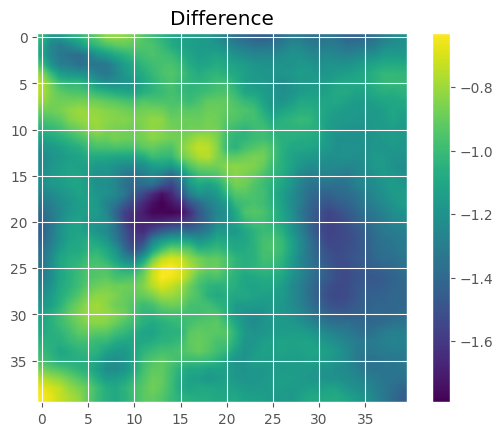

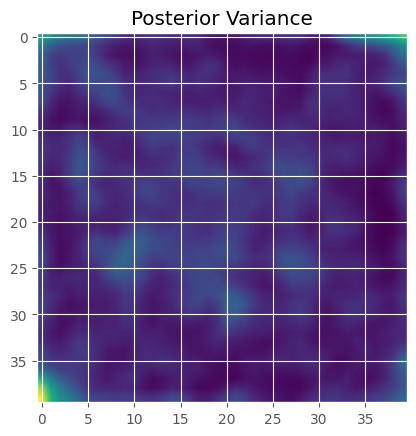

In [11]:
plt.subplot(1,2,1)
plt.title("Posterior Mean")
plt.imshow(np.mean(mcmc_samples,axis=0).reshape(40,40),interpolation = 'bilinear')
plt.subplot(1,2,2)
plt.title("True Solution")
plt.imshow(np.log(true_permeability),interpolation = 'bilinear')
plt.show()

plt.title("Difference")
plt.imshow(np.mean(mcmc_samples,axis=0).reshape(40,40) - true_permeability,interpolation = 'bilinear')
plt.colorbar()
plt.show()

plt.title("Posterior Variance")
plt.imshow(np.var(mcmc_samples,axis=0).reshape(40,40),interpolation = 'bilinear')
plt.show()

In [8]:
def plot_pair(plot1,plot2,title1='MCMC',title2='MGAN'):
    from matplotlib.colors import Normalize
    import matplotlib.cm as cm
    grid = np.linspace(0,1,10)[1:-1]
    x,y = np.meshgrid(grid,grid)
    x= x.flatten()
    y = y.flatten()



    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    cmap=cm.get_cmap('viridis')


    lower=np.min(np.minimum(plot1,plot2))
    upper=np.max(np.maximum(plot1,plot2))
    normalizer=Normalize(lower,upper)

    im=cm.ScalarMappable(norm=normalizer)
    for ax,image,title in zip(axes.flat,[plot1,plot2],[title1,title2]):
        ax.imshow(image,cmap=cmap,norm=normalizer,extent = [0,1,0,1],interpolation = 'quadric')
        ax.set_title(title)
        ax.scatter(x,y,c='black',s = 4)
    fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.5)
    plt.show()


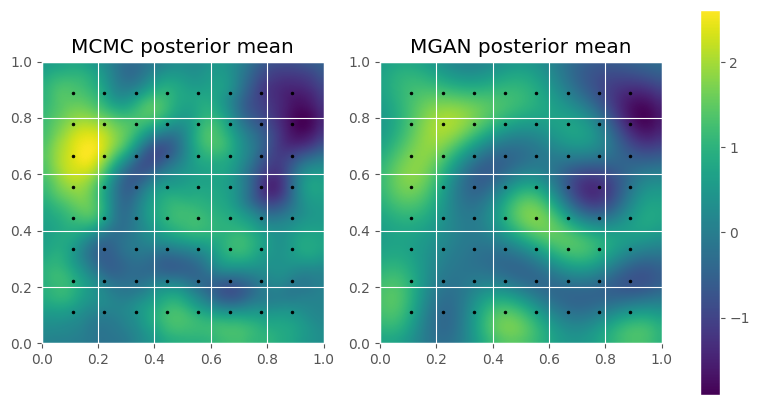

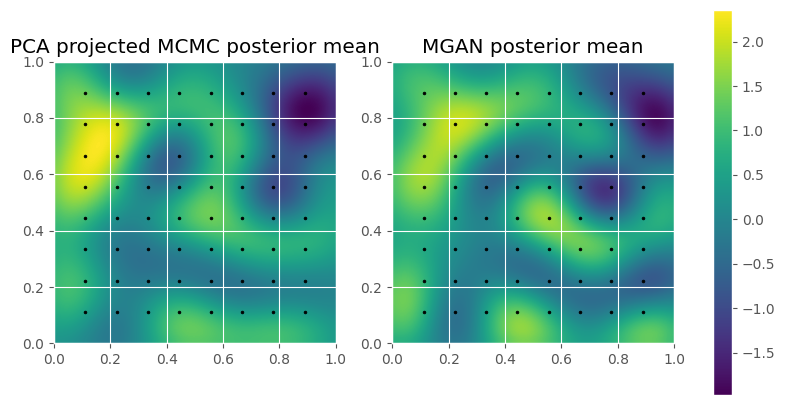

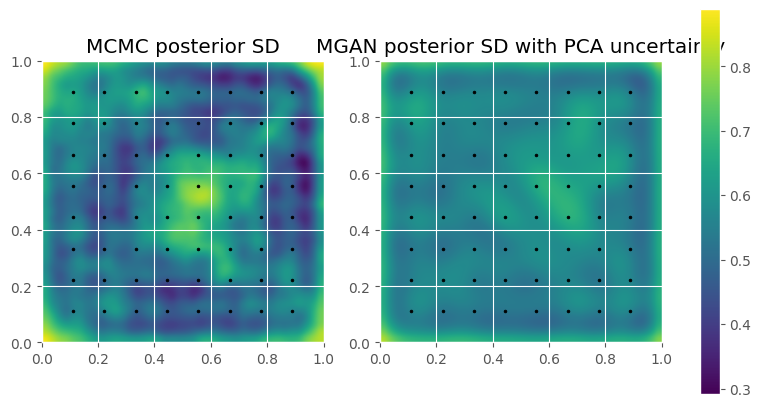

In [40]:
plot_pair(
    np.mean(mcmc_samples,axis=0).reshape(40,40),
    np.mean(mgan_samples,axis=0).reshape(40,40),
    "MCMC posterior mean",
    "MGAN posterior mean"
)
plot_pair(
    pca.inverse_transform(pca.transform(np.mean(mcmc_samples,axis=0))).reshape(40,40),
    np.mean(mgan_samples,axis=0).reshape(40,40),
    "PCA projected MCMC posterior mean",
    "MGAN posterior mean"
)

plot_pair(
    np.sqrt(np.var(mcmc_samples,axis=0).reshape(40,40)),
    np.sqrt(np.var(mgan_samples,axis=0).reshape(40,40)+extra_pca_variance),
    "MCMC posterior SD",
    "MGAN posterior SD with PCA uncertainty"
)




In [26]:
mcmc_sd=np.sqrt(np.var(mcmc_samples,axis=0).reshape(40,40)).flatten()
mgan_sd=np.sqrt(np.var(mgan_samples,axis=0).reshape(40,40)+extra_pca_variance).flatten()
mgan_sd_raw=np.sqrt(np.var(mgan_samples,axis=0).reshape(40,40)).flatten()

Text(0.5, 1.0, 'Comparison of standard deviations by point')

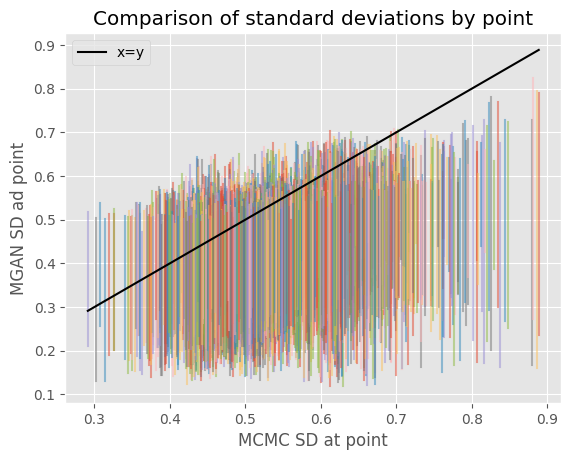

In [23]:
for mgan_lower,mgan_upper,mcmc_sd_val in zip(mgan_sd_raw,mgan_sd,mcmc_sd):
    plt.plot([mcmc_sd_val,mcmc_sd_val],[mgan_lower,mgan_upper],alpha=0.5)
plt.plot([np.min(mcmc_sd),np.max(mcmc_sd)],[np.min(mcmc_sd),np.max(mcmc_sd)],c='black',label = "x=y")
plt.xlabel("MCMC SD at point")
plt.ylabel("MGAN SD ad point")
plt.legend()
plt.title("Comparison of standard deviations by point")

In [28]:
np.mean(mgan_sd_raw)

0.2567700163241422

In [39]:
np.sum(pca.sigma[:40])/np.sum(pca.sigma)

0.7337497358168171

51215.25136203345

In [ ]:
plt.subplot(1,2,1)
plt.title("Posterior Mean")
plt.imshow(np.mean(mcmc_samples,axis=0).reshape(40,40))
plt.subplot(1,2,2)
plt.title("True Solution")
plt.imshow(true_permeability)
plt.show()
